<a href="https://colab.research.google.com/github/Fulim13/Parallel-Computing-Learning/blob/main/Practical4/06_Producer_Consumer_Exercise_Unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Producer Consumer Problem and Solution**
## **Goal**:
This will be an exercise to implement a solution to a producer consumer problem.

## **What is the Producer Consumer Problem?**
The producer-consumer problem is a synchronization challenge in concurrent programming. It involves two processes (threads):

1.   the **producer**, responsible for generating data and adding it to a shared buffer,
2.   the **consumer**, which removes data from the buffer.

To achieve this, synchronization between the producer and the consumer is necessary. Since the buffer has a finite capacity, the producer cannot keep adding messages to the queue if there are no empty slots available. Similarly, the consumer cannot retrieve messages if the buffer is empty. The algorithm ensures synchronization by blocking the producer when the buffer is full, unblocking it only when the consumer retrieves messages. Conversely, the consumer is blocked when the buffer is empty and unblocked only when the producer adds new messages to the buffer.

## **How to Block and Unblock Processes (Threads)?**
The core of the algorithm lies in its blocking and unblocking mechanisms:
1. **Producer**: Blocks when the buffer is full, unblocks when the buffer is not full.
2. **Consumer**: Blocks when the buffer is empty, unblocks when the buffer is not empty.

But how do we achieve this? For example, for the consumer, how do we block when the buffer is empty and unblock when it is not empty? One common way to do this is to use the **counting semaphore**.

## **What is Counting Semaphore?**
A **counting semaphore** is a synchronization mechanism used in operating systems to regulate access to finite shared resources. The semaphore maintains a count that represents the number of available resources. When a process or thread needs one of these resources, it attempts to decrement the count. If the count is greater than zero before the decrement, it means the resource is available, and the process can proceed without being blocked. However, if the count reaches zero, the process must wait until a resource becomes available. Counting semaphores can accommodate multiple processes (threads) accessing the shared resource simultaneously. If the initial count is 1, it allows exactly one thread to access the resource at a time. This special case of a counting semaphore is known as a **binary semaphore**. Due to this property, it is commonly used to control access to critical sections.

## **Semaphore Implementation**
In C++, the standard library provides the `std::counting_semaphore` class, which can be readily used for managing synchronization among threads. However, for this specific exercise, we'll create our own counting semaphore using a conditional variable in conjunction with a mutex. This custom approach allows us to precisely track when a thread becomes blocked or unblocked during the up (release) or down (acquire) operation—a feature not directly available in the standard counting semaphore. The primary purpose of implementing our own semaphore is to facilitate debugging. By monitoring whether a thread is blocked or unblocked, we gain insights into potential issues within our concurrent code.

In [ ]:
# Do not confuse with the standard semaphore library provided by C++ although
# the name used for this file is the same. This is our custom semaphore
# implementation.
%%writefile semaphore.hpp
#pragma once
#include <iostream>
#include <thread>
#include <mutex>
#include <condition_variable>

#define sem_down(obj)   (obj.acquire(#obj))
#define sem_up(obj)     (obj.release(#obj))

class Semaphore {
private:
    int count;
    bool blocked = false;
    std::condition_variable cv;
    std::mutex mtx;

public:
    Semaphore(int count_) : count(count_) {}

    void acquire(const char *name) {
        std::unique_lock<std::mutex> lock(mtx);
        //std::cout << name << " is " << count << "\n";
        if(count <= 0) {
            std::cout << "Block on " << name << "\n";
            blocked = true;
        }
        do {
             cv.wait(lock, [this] { return count > 0; });
        } while (count <= 0);
        if(blocked) {
            std::cout << "Unblock from " << name << "\n";
            blocked = false;
        }
        --count;
    }

    void release(const char *name) {
        std::unique_lock<std::mutex> lock(mtx);
        ++count;
        cv.notify_one();
    }
};

Writing semaphore.hpp


## **Barrier Example Solved Using the Custom Counting Semaphore**
This is a barrier example is merely to serve as a test program to check the correctness of the custom semaphore implementation. It creates 10 threads, each of which will block by calling `sem_down(barrier)`. The last thread bypasses the `sem_down(barrier)` and calls `sem_up(barrier)`, which unblocks one waiting thread. That thread proceeds to call `sem_up(barrier)`, which releases the next thread. This chain reaction eventually releases all the waiting threads.

Take note of how the custom counting semaphore is used:
1.  `Semaphore barrier(0)` creates a counting semaphore with an initial count of 0.
2.  `sem_down(barrier)` calls the `acquire()` method of the barrier semaphore object.
3.  `sem_up(barrier)` calls the `release()` method of the barrier semaphore object.

In [ ]:
%%writefile barrier_example.cpp
#include <iostream>
#include <pthread.h>
#include "semaphore.hpp"        // This is our custom semaphore implementation

const int THREAD_SIZE = 10;     // The number of threads

Semaphore mutex(1);             // Create a binary semaphore to serve as a mutex
Semaphore barrier(0);           // Semaphore with initial count of 0
int count = 0;

void* demo_barrier_synchronization(void *s) {
    std::cout << "Message: " << *static_cast<std::string*>(s) << std::endl;

    sem_down(mutex);
    count++;                    // Count the number of threads
    sem_up(mutex);

    if (count != THREAD_SIZE)   // , then this must NOT be the last thread
        sem_down(barrier);      // so it has to wait
    // The last thread will unblock ONE thread
    sem_up(barrier);            // Once unblocked, it unblocks the next thread

    std::cout << *static_cast<std::string*>(s) << " unblocked\n";
    delete static_cast<std::string*>(s);
    return NULL;
}

int main() {
    pthread_t t[THREAD_SIZE];
    // Create threads with each executing demo_barrier_sync
    for(int i = 0; i < THREAD_SIZE; i++) {
        std::string *str = new std::string{"thread_" + std::to_string(i)};
        pthread_create(&t[i], nullptr, demo_barrier_synchronization,          \
                        static_cast<void*>(str));
    }
    // Join all the threads
    for(int i = 0; i < THREAD_SIZE; i++) {
        pthread_join(t[i], nullptr);
    }
    return 0;
}

Writing barrier_example.cpp


In [ ]:
!g++ -o barrier_example barrier_example.cpp
!./barrier_example

Message: thread_2
Block on barrier
Message: thread_8
Block on barrier
Message: thread_9
Block on barrier
Message: thread_1
Block on barrier
Message: thread_5
Block on barrier
Message: Message: thread_4
Block on barrier
Message: Message: thread_3
Block on barrier
thread_6
Block on barrier
thread_7
Block on barrier
Message: thread_0
Unblock from barrier
thread_2 unblocked
thread_0 unblocked
thread_8 unblocked
thread_1 unblocked
thread_4 unblocked
thread_3 unblocked
thread_6 unblocked
thread_5 unblocked
thread_7 unblocked
thread_9 unblocked


We have digressed a bit, but let's get back to the producer and consumer.

## **How Many Counting Semaphore Needed to Solve the Producer Consumer Problem?**
Obviously, we need 2 counting semaphores, namely, one to control the access to the buffer by the producer and the other for the consumer.


## **The Consumer is Straightforwardly Handled by the Counting Semaphore, But How to Deal with the Producer?**
The counting semaphore works well for the consumer because we want the consumer to be blocked when the count (representing available resources) reaches zero. When the count is zero, the consumer waits until a resource becomes available. For the producer, we need it to be blocked when the buffer is full (all slots are occupied). Using the semaphore count directly to track the number of resources won't work because the semaphore is blocked only when the count reaches zero. To address this, we rephrase the context: Instead of counting available resources, we use the semaphore count to track the empty slots in the buffer. When the buffer is full (empty slots reach zero), the producer is blocked until a slot becomes available.

Here is how the counting semaphores are defined for the producer consumer algorithm:
```cpp
// Semaphore to count available resources. Initially, the buffer is empty.
Semaphore resource_count(0);
// Semaphore to count empty slots. Initially, the empty slots is the size of the buffer.
Semaphore empty_slot_count(BUFFER_SIZE);
```
Note that the `resource_count` and `empty_slot_count` are complementary. When the `resource_count` decreases by 1 (due to a consumer consuming 1 resource), the `empty_slot_count` increases by 1 (indicating to the producer an additional empty slot is available for it to use). Similarly, when the `empty_slot_count` decreases by 1 (because the producer uses up 1 empty slot), the resource_count increases by 1 (signaling to the consumer that additional resources are available for consumption).

## **The Finite Circular Buffer**
To be able to store and retrieve data in an efficient manner, we use a finite circular buffer with a specific size. The implementation of this buffer is given in the following code.

The implementation can self-test to determine if:

1.   It encounters a race condition (meaning many threads access it at the same time)
2.   A caller attempts to add an item exceeding its full capacity (meaning the caller fails to block on full)
3.   A caller attempts to remove an item when the buffer is empty (meaning the caller fails to block on empty)

The implementation prints error messages to inform the user of these 3 issues. This can be helpful for debugging. However, the implementation cannot detect deadlock scenarios. If a deadlock were to occur, the program would appear to hang without any explicit error messages.

Note that the self-test code is only there to guide you in solving the problem. In the actual circular buffer implementation, such redundant code is not included.

In [ ]:
%%writefile circular_buffer.hpp
#pragma once
#include <mutex>
#include <string>
#include <chrono>

class CircularBuffer {
public:
    // Constructor
    CircularBuffer(size_t size) : size(size), head_idx(0), tail_idx(0) {
        buffer = new int[size];
    }

    // Destructor
    ~CircularBuffer() {
       delete []buffer;
    }

    void add_integer(int value) {
        verify_mutual_exclusive_enter("add_integer");
        verify_count_before_adding("add_integer");
        buffer[tail_idx] = value;
        std::this_thread::sleep_for(std::chrono::milliseconds(10));
        tail_idx = (tail_idx + 1) % size;
        verify_mutual_exclusive_exit("add_integer");
    }

    int get_integer() {
        verify_mutual_exclusive_enter("get_integer");
        verify_count_before_removing("get_integer");
        int value = buffer[head_idx];
        std::this_thread::sleep_for(std::chrono::milliseconds(10));
        head_idx = (head_idx + 1) % size;
        verify_mutual_exclusive_exit("get_integer");
        return value;
    }

private:
    void verify_mutual_exclusive_enter(std::string str) {
        std::unique_lock<std::mutex> lock(mutex_);
        if(enter_count > 0) {
            std::cout << "BUG: [" << str << "] Non-mutual exclusive access "
                      << "to the CircularBuffer object. Has already entered "
                      << enter_count << " time! May potentially encounter "
                      << "race condition!\n";
            std::terminate();
        }
        enter_count++;
        //std::cout << "DEBUG: [" << str << ":enter] enter_count = "          \
                << enter_count << " time(s).\n";
    }

    void verify_mutual_exclusive_exit(std::string str) {
        std::unique_lock<std::mutex> lock(mutex_);
        if(enter_count < 1) {
            std::cout << "BUG: [" << str << "] Illegal exclusive access to the "
                      << "CircularBuffer object. Has already exited "
                      << -enter_count << " time!\n";
            std::terminate();
        }
        enter_count--;
        // std::cout << "DEBUG: [" << str << ":exit] enter_count = "\
                << enter_count << " time(s).\n";
    }

    void verify_count_before_adding(std::string str) {
        std::unique_lock<std::mutex> lock(mutex_);
        if(++count > size) {
            std::cout << "BUG: [" << str << "] Attempting to add data "
                      << "exceeding the buffer size! Most probably it is not "
                      << "protected by a counting semaphore!\n";
            std::terminate();
        }
        //std::cout << "DEBUG: [" << str << ":enter] count = "          \
                << count << " item(s).\n";
    }

    void verify_count_before_removing(std::string str) {
        std::unique_lock<std::mutex> lock(mutex_);
        if(--count < 0) {
            std::cout << "BUG: [" << str << "] Attempting to remove data from "
                      << "an empty buffer! Most probably it is not "
                      << "protected by a counting semaphore!\n";
            std::terminate();
        }
    }

    std::mutex mutex_;
    int count = 0;
    int enter_count = 0;
    int *buffer;
    size_t size;
    size_t head_idx;
    size_t tail_idx;
};


Writing circular_buffer.hpp


## **Main Program**
This is the main program of the producer-consumer problem exercise. The `main()` function creates two threads - one to run the `sender()` function and another to run the `receiver()` function.

The `sender()` produces a monotonically increasing number and sends it to a finite circular buffer of size 12. It generates these numbers in random bursts. Conversely, the `receiver()` consumes the numbers from the buffer and prints them to the console, also in random bursts.

The random bursts allow the buffer to fill and clear quickly at different times. This variation in fill and consumption rates is intentional - it will allow us to thoroughly test the producer-consumer code and ensure it functions correctly under diverse operating conditions.

Specifically, if the producer fills the buffer quickly to its maximum capacity of 12, it will block on the `empty_slots_count` semaphore, since it cannot add any more items when there are no empty slots available. Conversely, if the consumer consumes the items quickly until the buffer is empty, it will block on the `resource_count` semaphore, as it cannot retrieve any more items when the buffer is depleted.

By subjecting the system to these random fill and consumption patterns, we can validate that the producer and consumer threads are properly synchronizing access to the shared buffer using the semaphores, preventing race conditions and deadlocks.

In [ ]:
%%writefile sender_receiver.cpp
#include <iostream>
#include <ctime>
#include <thread>
#include "send_recv.hpp"
#include "rand.hpp"

namespace this_thread = std::this_thread;
namespace chrono = std::chrono;
using milliseconds = chrono::milliseconds;
using uint32 = unsigned int;

const int N = 500;
const uint32 MIN = 0;
const uint32 MAX = 100000;

RandomGen rd, delay(BUFFER_SIZE / 2);

void sender(CircularBuffer &buffer) {
    int value = 0;
    for(int i = 0; i < N; i++) {
        // Generate a none zero random value
        do {
            //value = rd.gen(MIN, MAX);
            value++;
        } while(value == 0);
        // Send the number
        send(value, buffer);
        // Sleep for some random period from 0 to 0.5 second
        this_thread::sleep_for(milliseconds(delay.gen(0, 500)));
    }
    // Send a 0 to terminate
    send(0, buffer);
}

void receiver(CircularBuffer &buffer) {
    int value;
    // Print the number received as long as it is not zero. Otherwise,
    // stop this thread
    while((value = recv(buffer)) != 0) {
        std::cout << "Number received: " << value << std::endl << std::flush;
        this_thread::sleep_for(milliseconds(delay.gen(0, 500)));
    }
}

int main() {
    CircularBuffer buffer(BUFFER_SIZE);

    std::thread prodThread(sender, std::ref(buffer));
    std::thread consThread(receiver, std::ref(buffer));

    prodThread.join();
    consThread.join();

    std::cout << "Program ended." << std::endl << std::flush;

    return 0;
}

Writing sender_receiver.cpp


In [ ]:
%%writefile rand.hpp
#pragma once
#include <random>
#include <mutex>

using uint32 = unsigned int;

class RandomGen {
public:
    //RandomGen() = default;
    RandomGen(uint32 burst_size = 0) {
        if(burst_size < 0)
            this->burst_size = 0;
        else this->burst_size = burst_size;;
        rd_gen = std::uniform_int_distribution<uint32>{0, this->burst_size};
    }

    RandomGen(std::mt19937::result_type seed, uint32 burst_size = 0) :       \
                                                        RandomGen(burst_size) {
        eng.seed(seed);
    }

    uint32 gen(uint32 min, uint32 max) {
        std::unique_lock<std::mutex> lock(mutex_);
        if(i < 1) {
            i = rd_gen(eng);
            return std::uniform_int_distribution<uint32>{min, max}(eng);
        } else {
            i--;
            return std::uniform_int_distribution<uint32>{0, 50}(eng);;
        }
    }
/*
    float gen(float min, float max) {
        return std::uniform_real_distribution<float>{min, max}(eng);
    }
*/
private:
    std::mutex mutex_;
    std::mt19937 eng{std::random_device{}()};
    std::uniform_int_distribution<uint32> rd_gen;
    uint32 burst_size;
    int i = 0;
};

Writing rand.hpp


## **The Producer Consumer Code**
This is the code that implements the solution for the producer-consumer problem. Fill in the code as suggested in the comments to make the program work. Note that although there are two semaphores used to synchronize access to the buffer by the producer and consumer, it does not guarantee mutually exclusive access when manipulating the shared buffer. Therefore, we need a mutex to prevent race conditions.

In [ ]:
%%writefile send_recv.cpp
#include <iostream>
#include <mutex>
#include <semaphore.h>
#include "semaphore.hpp"
#include "send_recv.hpp"

// Count the number of resource in the buffer
Semaphore resource_count(0);
// Count the number of empty slots in the buffer
Semaphore empty_slots_count(BUFFER_SIZE);
// Mutex to protect the shared circular buffer from race condition
std::mutex buf_mut;

// Implement the producer
void send(int data, CircularBuffer &buffer) {
    // Perform a down on empty_slots_count, it should block when there is no
    // more empty slots to fill item. Otherwise it will just proceeds.
    // ...

    // Before accessing the shared finite circular buffer, acquire mutex first
    // ...

    // Add the data into the buffer
    buffer.add_integer(data);

    // Release the mutex when done with the critical section
    // ...

    // Perform an up on the resource count because we have just added an item
    // ...
}

// Implement the consumer
int recv(CircularBuffer &buffer) {
    // Perform a down on resource_count, it should block when there is no
    // more resource to consume. Otherwise it will just proceeds.
    // ...

    // Before accessing the shared finite circular buffer, acquire mutex first
    // ...

    // Get the data from the buffer
    int value = buffer.get_integer();

    // Release the mutex when done with the critical section
    // ...

    // Perform an up on the resource count because we have just added an item
    // ...

    // Return the retrieved data
    return value;
}

Writing send_recv.cpp


This is the header file for the `send_recv.cpp`. It is already completed, and no coding required here.

In [ ]:
%%writefile send_recv.hpp
#pragma once
#include "circular_buffer.hpp"

using uint32 = unsigned int;
const uint32 BUFFER_SIZE = 12;

void send(int data, CircularBuffer &buffer);
int recv(CircularBuffer &buffer);

Writing send_recv.hpp


## **Compilation and Running the Producer Consumer Program**
Run this cell to see the result. If an error is generated, fix the `send_recv.cpp` code, recompile, and run again. If the program is running for too long, you can stop it by clicking the stop button.

You can adjust the `BUFFER_SIZE` of the finite circular buffer in the `send_recv.hpp` file if you wish.

The program is set to send 500 integers by default. You can change the value of `N` in the `sender_receiver.cpp` file if you wish to run the test with a smaller sample size. However, please note that if `N` is set too low, the program may not be able to effectively detect any bugs in your code.

A functional code should give you result like the following:

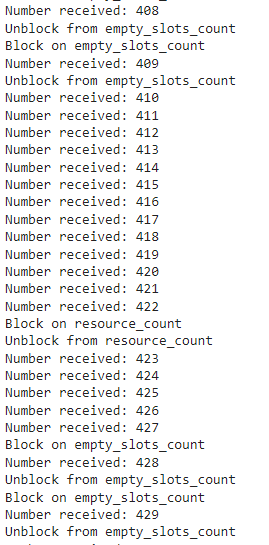

In [ ]:
!g++ -o sender_receiver sender_receiver.cpp send_recv.cpp
!./sender_receiver

BUG: [get_integer] Attempting to remove data from an empty buffer! Most probably it is not protected by a counting semaphore!
terminate called without an active exception
